# Neural Networks Project - Gesture Recognition for Smart TVs 

<div style="margin-top: 1.5rem">
    Presented by:
    <br />
    <i>Shantnu Kumar Singh</a></strong></i>
    <br />
    <i>Sharan Abhishek</a></strong></i>
</div>

### Problem Statement

As a data scientist at a home electronics company specializing in advanced smart televisions, the objective is to develop a feature enabling the recognition of five distinct gestures performed by users. This feature aims to facilitate TV control without the need for a remote. The gestures, which include thumbs up, thumbs down, left swipe, right swipe, and stop, correspond to specific commands such as volume adjustment, playback control, and skipping within a video.

The dataset comprises several hundred videos, each categorized into one of the five gesture classes. Each video consists of a sequence of 30 frames captured by a webcam mounted on the TV. The training data is organized into 'train' and 'val' folders, with corresponding CSV files containing information about the videos and their labels. Additionally, the data is stored in subfolders, each representing a video of a particular gesture.

The videos exhibit varying dimensions, either 360x360 or 120x160, depending on the webcam used for recording. Therefore, preprocessing is necessary to standardize the videos before model training. Each row in the CSV files represents a video and includes the subfolder name containing the video frames, the gesture label, and a numeric label (ranging from 0 to 4).

The task entails training a model on the 'train' folder to perform well on the 'val' folder, adhering to standard practices in machine learning projects. The test folder is withheld for evaluation purposes, and the final model's performance will be assessed on this set.

To initiate the model building process, the first step is to obtain the dataset and store it locally. This can be accomplished by following the provided steps:

1. Open the terminal.
2. Go to following link: `https://drive.google.com/drive/folders/1kPwCFhnK9e6Lk61CRUhCt0G3ZulmS5dp`
3. Unzip the downloaded file named 'Project_data.zip'.

### 1. Importing the libraries

In [17]:
#pip install opencv-python

In [18]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio.v2 as imageio
import skimage
from skimage.transform import resize
import datetime
import cv2
import abc
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.applications import mobilenet
import tensorflow as tf
import random as rn
import warnings
warnings.filterwarnings("ignore")
import PIL

In [19]:
# Setting the random state to replicate the output

np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [20]:
# Add the root folder name as base path
base_path = '/home/extracted_data/Project_data'

### Solution Overview

We will be using Convolutional Neural Network (CNN) combined with Recurrent Neural Network (RNN) architecture.
In this architecture, the Conv2D network extracts a feature vector for each image, and subsequently, a sequence of these feature vectors is inputted into an RNN-based network. The output of the RNN is a conventional softmax.

We'll establish a class `ModelBuilder` that serves as an abstract foundation for constructing models and data generators tailored for gesture recognition in smart TVs. This class encompasses functionalities for setting up paths, image properties, hyperparameters, and generating training data batches. Furthermore, it incorporates a method for model training and an abstract method for specifying the model architecture.

In [21]:
class ModelBuilder(metaclass=abc.ABCMeta):
    """
    Abstract base class for building models and data generators.
    """

    def initialize_path(self, base_path):
        """
        Initialize paths for training and validation data.

        Args:
        - base_path (str): Base directory path containing train.csv and val.csv.

        Returns:
        - None
        """
        self.train_doc = np.random.permutation(open(base_path + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(base_path + '/' + 'val.csv').readlines())
        self.train_path = base_path + '/' + 'train'
        self.val_path = base_path + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_props(self, image_height=100, image_width=100):
        """
        Initialize properties related to images.

        Args:
        - image_height (int): Height of the images.
        - image_width (int): Width of the images.

        Returns:
        - None
        """
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
          
    def initialize_hyperparameters(self, number_of_sample_frames=30, batch_size=20, num_epochs=20):
        """
        Initialize hyperparameters for training.

        Args:
        - number_of_sample_frames (int): Number of sample frames.
        - batch_size (int): Batch size for training.
        - num_epochs (int): Number of epochs for training.

        Returns:
        - None
        """
        self.number_of_sample_frames = number_of_sample_frames
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        
    def generator(self, source_path, folder_list, augment=False):
        """
        Generator function for creating batches of data.

        Args:
        - source_path (str): Path to the source directory containing video frames.
        - folder_list (list): List of folders containing video frames.
        - augment (bool): Whether to perform data augmentation.

        Yields:
        - batch_data (numpy array): Batch of input data.
        - batch_labels (numpy array): Batch of corresponding labels.
        """
        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.number_of_sample_frames, dtype=int))
        batch_size = self.batch_size
        
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels 

            remaining_samples = len(t) % batch_size
        
            if (remaining_samples != 0):
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_samples)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_samples=0):
        """
        Fetch one batch of data.

        Args:
        - source_path (str): Path to the source directory containing video frames.
        - t (list): List of folders containing video frames.
        - batch (int): Batch index.
        - batch_size (int): Batch size.
        - img_idx (numpy array): Indices of frames to be considered.
        - augment (bool): Whether to perform data augmentation.
        - remaining_samples (int): Number of remaining samples in the last batch.

        Returns:
        - batch_data (numpy array): Batch of input data.
        - batch_labels (numpy array): Batch of corresponding labels.
        """
    
        seq_length = remaining_samples if remaining_samples else batch_size
    
        batch_data = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels)) 
        batch_labels = np.zeros((seq_length, self.num_classes)) 
    
        if (augment):
            batch_data_aug = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels))

        
        for folder in range(seq_length): 
            imgs = os.listdir(source_path + '/' + t[folder + (batch*batch_size)].split(';')[0]) 
            for idx, item in enumerate(img_idx): 
                image = imageio.imread(source_path + '/' + t[folder + (batch*batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                image_resized = resize(image, (self.image_height, self.image_width, 3))
            
            
                # Normalization of RGB channels
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)], [0, 1, np.random.randint(-30, 30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped = shifted[x0:x1, y0:y1, :]
                    
                    image_resized = resize(cropped, (self.image_height, self.image_width, 3))
            
                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        
        return(batch_data, batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        """
        Train the model.

        Args:
        - model: Model to be trained.
        - augment_data (bool): Whether to augment the training data.

        Returns:
        - history: Training history.
        """
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        # Create a directory with model name and current datetime
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        # Generate model file inside the created folder
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

        # Add model checkpoint
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
        
        # Add learning rate
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        # Calculate steps per epoch
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        # Fit the model
      # history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
       #                     callbacks=callbacks_list, validation_data=val_generator, 
        #                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
       
        return history

        
    @abc.abstractmethod
    def model_definition(self):
        """
        Abstract method for defining the model architecture.
        """
        pass


### Visualization of Training and Validation Metrics

This can be achieved by utilizing the `plot` function, which generates visualizations for the training and validation loss, as well as `categorical accuracy` and `validation categorical accuracy`. It relies on the training metrics stored in the history object returned by `model.fit()`. The resulting plot includes two subplots, each displaying the trend of a specific metric across epochs.

In [22]:
def plot(history):
    """
    Plots training and validation loss, as well as categorical accuracy and validation categorical accuracy.

    Args:
    - history: History object returned by model.fit(), containing training metrics.

    Returns:
    - None
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss', 'val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy', 'val_categorical_accuracy'])

### Model 1 - CNN with LSTM

In [23]:
class RNNCNN1(ModelBuilder):
    
    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
            input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
#       optimizer = tf.keras.optimizers.legacy.Adam()
        optimizer = tf.keras.optimizers.Adam()

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [24]:
rnn_cnn_1 = RNNCNN1()
rnn_cnn_1.initialize_path(base_path)
rnn_cnn_1.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_1.initialize_hyperparameters(number_of_sample_frames=30, batch_size=20, num_epochs=20)
rnn_cnn_model_1 = rnn_cnn_1.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32)   1

In [25]:
#model.add(Dense(dense_neurons, activation='relu'))
#model.add(Dropout(dropout))
#model.add(Dense(self.num_classes, activation='softmax'))
#optimizer = tf.keras.optimizers.Adam()  # Updated optimizer
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [26]:
print("Total Parameters: ", rnn_cnn_model_1.count_params())


Total Parameters:  1657445


In [11]:
model_1 = rnn_cnn_1.train_model(rnn_cnn_model_1, augment_data=True)

Epoch 1/20


2025-03-30 14:09:08.690936: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.3797 - categorical_accuracy: 0.4299
Epoch 00001: saving model to model_init_2025-03-3014_08_58.487184/model-00001-1.37970-0.42986-1.73270-0.22000.keras
34/34 [==============================] - 284s 8s/step - loss: 1.3797 - categorical_accuracy: 0.4299 - val_loss: 1.7327 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0238 - categorical_accuracy: 0.6056
Epoch 00002: saving model to model_init_2025-03-3014_08_58.487184/model-00002-1.02376-0.60558-1.93623-0.24000.keras
34/34 [==============================] - 278s 8s/step - loss: 1.0238 - categorical_accuracy: 0.6056 - val_loss: 1.9362 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8544 - categorical_accuracy: 0.6719
Epoch 00003: saving model to model_init_2025-03-3014_08_58.487184/model-00003-0.85444-0.67195-2.86426-0.22000.keras
34/34 [====

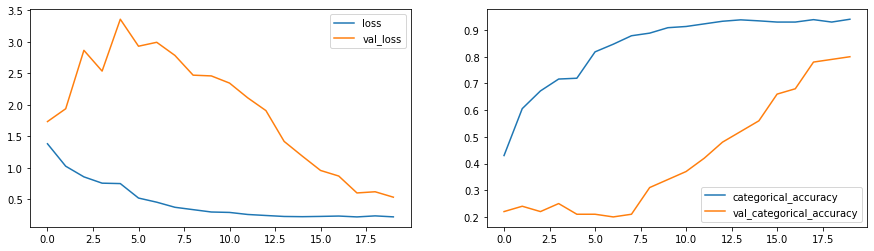

In [12]:
plot(model_1)

***Observations:***

Utilizing the base CNN with LSTM architecture, we conducted training on all frames (30) extracted from the video. The training accuracy reached 92%, while the validation accuracy attained 76%, revealing potential signs of overfitting. To address this, we aim to explore a modified version of the same model by reducing the number of frames, batch size and number of epochs.

### Model 2 - CNN with LSTM (with reduced hyperparameters)

In [27]:
rnn_cnn_2 = RNNCNN1()
rnn_cnn_2.initialize_path(base_path)
rnn_cnn_2.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_2.initialize_hyperparameters(number_of_sample_frames=20, batch_size=10, num_epochs=10)
rnn_cnn_model_2 = rnn_cnn_2.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 20, 60, 60, 32)  

In [14]:
print("Total Parameters: ", rnn_cnn_model_2.count_params())
model_2 = rnn_cnn_2.train_model(rnn_cnn_model_2, augment_data=True)

Total Parameters:  1657445
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.3863 - categorical_accuracy: 0.3808
Epoch 00001: saving model to model_init_2025-03-3015_43_05.384830/model-00001-1.38632-0.38084-1.68507-0.19000.keras
67/67 [==============================] - 193s 3s/step - loss: 1.3863 - categorical_accuracy: 0.3808 - val_loss: 1.6851 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.1140 - categorical_accuracy: 0.5520
Epoch 00002: saving model to model_init_2025-03-3015_43_05.384830/model-00002-1.11399-0.55204-2.13379-0.22000.keras
67/67 [==============================] - 190s 3s/step - loss: 1.1140 - categorical_accuracy: 0.5520 - val_loss: 2.1338 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 0.9459 - categorical_accuracy: 0.6297
Epoch 00003: saving model to model_init_2025-03-3015_43_05.384830/model-00003-0.94594-0.6

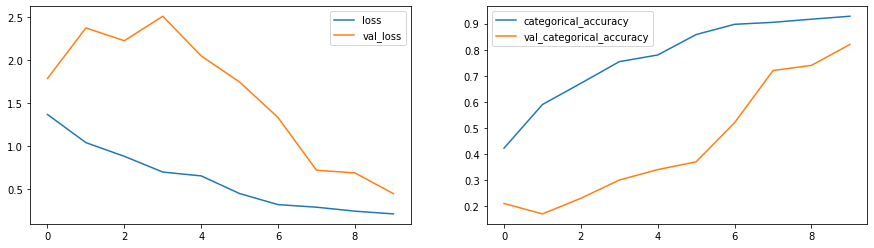

In [18]:
plot(model_2)

***Observations:***

Upon reducing the number of hyperparameters, the training accuracy drops to 89%, and the validation accuracy decreases to 78%, indicating underfitting. To address this issue, we will attempt to alleviate it by solely reducing the number of frames while keeping both the batch size and the number of epochs at 20.

### Model 3 - CNN with LSTM (with reduced frames)

In [28]:
rnn_cnn_3 = RNNCNN1()
rnn_cnn_3.initialize_path(base_path)
rnn_cnn_3.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_3.initialize_hyperparameters(number_of_sample_frames=18, batch_size=20, num_epochs=20)
rnn_cnn_model_3 = rnn_cnn_3.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 18, 60, 60, 32)  

In [20]:
print("Total Parameters: ", rnn_cnn_model_3.count_params())
model_3 = rnn_cnn_3.train_model(rnn_cnn_model_3, augment_data=True)

Total Parameters:  1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3196 - categorical_accuracy: 0.4563
Epoch 00001: saving model to model_init_2025-03-3011_32_43.442203/model-00001-1.31959-0.45626-1.65929-0.21000.keras
34/34 [==============================] - 107s 3s/step - loss: 1.3196 - categorical_accuracy: 0.4563 - val_loss: 1.6593 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0220 - categorical_accuracy: 0.6192
Epoch 00002: saving model to model_init_2025-03-3011_32_43.442203/model-00002-1.02195-0.61916-2.02100-0.22000.keras
34/34 [==============================] - 108s 3s/step - loss: 1.0220 - categorical_accuracy: 0.6192 - val_loss: 2.0210 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8292 - categorical_accuracy: 0.7014
Epoch 00003: saving model to model_init_2025-03-3011_32_43.442203/model-00003-0.82919-0.7

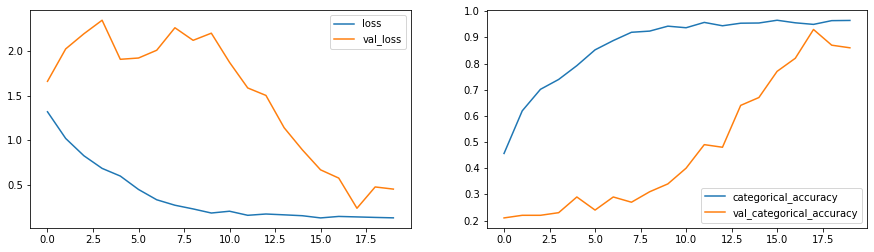

In [21]:
plot(model_3)

***Observations:***

The training accuracy demonstrates consistent improvement, achieving 87%, while the validation accuracy reaches a maximum of 74%, continuing to indicate potential overfitting. To address this concern, we aim to experiment with an alternative architecture, combining CNN with GRU, while maintaining the same number of frames.

### Model 4 - CNN with GRU

In [29]:
class RNNCNN2(ModelBuilder):
    
    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
            input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [30]:
rnn_cnn_4 = RNNCNN2()
rnn_cnn_4.initialize_path(base_path)
rnn_cnn_4.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_4.initialize_hyperparameters(number_of_sample_frames=18, batch_size=20, num_epochs=20)
rnn_cnn_model_4 = rnn_cnn_4.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 18, 60, 60, 32)  

In [24]:
print("Total Parameters: ", rnn_cnn_model_4.count_params())
model_4 = rnn_cnn_4.train_model(rnn_cnn_model_4, augment_data=True)

Total Parameters:  2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4062 - categorical_accuracy: 0.3831
Epoch 00001: saving model to model_init_2025-03-3012_16_34.596002/model-00001-1.40620-0.38311-1.66527-0.16000.keras
34/34 [==============================] - 107s 3s/step - loss: 1.4062 - categorical_accuracy: 0.3831 - val_loss: 1.6653 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9359 - categorical_accuracy: 0.6433
Epoch 00002: saving model to model_init_2025-03-3012_16_34.596002/model-00002-0.93587-0.64329-1.83871-0.21000.keras
34/34 [==============================] - 107s 3s/step - loss: 0.9359 - categorical_accuracy: 0.6433 - val_loss: 1.8387 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7259 - categorical_accuracy: 0.7443
Epoch 00003: saving model to model_init_2025-03-3012_16_34.596002/model-00003-0.7

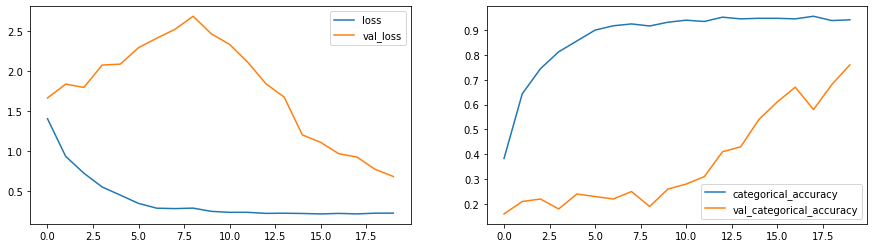

In [25]:
plot(model_4)

***Observations:***

By incorporating GRU-RNN, there is a marginal decline in training accuracy, reaching 92.6%, whereas the validation accuracy decreased to 66%, indicating overfitting. To tackle this issue, we propose introducing additional augmentation techniques such as rotation and reattempting the same architecture to mitigate overfitting.

### Enhance `ModelBuilder` class to incorporate additional augmentation techniques such as `Rotation`

In [31]:
class ModelBuilderWithRotation(metaclass=abc.ABCMeta):
    """
    Abstract base class for building models and data generators.
    """

    def initialize_path(self, base_path):
        """
        Initialize paths for training and validation data.

        Args:
        - base_path (str): Base directory path containing train.csv and val.csv.

        Returns:
        - None
        """
        self.train_doc = np.random.permutation(open(base_path + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(base_path + '/' + 'val.csv').readlines())
        self.train_path = base_path + '/' + 'train'
        self.val_path = base_path + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_props(self, image_height=100, image_width=100):
        """
        Initialize properties related to images.

        Args:
        - image_height (int): Height of the images.
        - image_width (int): Width of the images.

        Returns:
        - None
        """
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
          
    def initialize_hyperparameters(self, number_of_sample_frames=30, batch_size=20, num_epochs=20):
        """
        Initialize hyperparameters for training.

        Args:
        - number_of_sample_frames (int): Number of sample frames.
        - batch_size (int): Batch size for training.
        - num_epochs (int): Number of epochs for training.

        Returns:
        - None
        """
        self.number_of_sample_frames = number_of_sample_frames
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        
    def generator(self, source_path, folder_list, augment=False):
        """
        Generator function for creating batches of data.

        Args:
        - source_path (str): Path to the source directory containing video frames.
        - folder_list (list): List of folders containing video frames.
        - augment (bool): Whether to perform data augmentation.

        Yields:
        - batch_data (numpy array): Batch of input data.
        - batch_labels (numpy array): Batch of corresponding labels.
        """
        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.number_of_sample_frames, dtype=int))
        batch_size = self.batch_size
        
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels 

            remaining_samples = len(t) % batch_size
        
            if (remaining_samples != 0):
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_samples)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_samples=0):
        """
        Fetch one batch of data.

        Args:
        - source_path (str): Path to the source directory containing video frames.
        - t (list): List of folders containing video frames.
        - batch (int): Batch index.
        - batch_size (int): Batch size.
        - img_idx (numpy array): Indices of frames to be considered.
        - augment (bool): Whether to perform data augmentation.
        - remaining_samples (int): Number of remaining samples in the last batch.

        Returns:
        - batch_data (numpy array): Batch of input data.
        - batch_labels (numpy array): Batch of corresponding labels.
        """
    
        seq_length = remaining_samples if remaining_samples else batch_size
    
        batch_data = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels)) 
        batch_labels = np.zeros((seq_length, self.num_classes)) 
    
        if (augment):
            batch_data_aug = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels))

        
        for folder in range(seq_length): 
            imgs = os.listdir(source_path + '/' + t[folder + (batch*batch_size)].split(';')[0]) 
            for idx, item in enumerate(img_idx): 
                image = imageio.imread(source_path + '/' + t[folder + (batch*batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                image_resized = resize(image, (self.image_height, self.image_width, 3))
            
            
                # Normalization of RGB channels
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)], [0, 1, np.random.randint(-30, 30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped = shifted[x0:x1, y0:y1, :]
                    
                    image_resized = resize(cropped, (self.image_height, self.image_width, 3))
                    
                    matrix2d = cv2.getRotationMatrix2D((self.image_width//2, self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, matrix2d, (self.image_width, self.image_height))
            
                    batch_data_aug[folder, idx, :, :, 0] = (rotated[:, :, 0])/255
                    batch_data_aug[folder, idx, :, :, 1] = (rotated[:, :, 1])/255
                    batch_data_aug[folder, idx, :, :, 2] = (rotated[:, :, 2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        
        return(batch_data, batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        """
        Train the model.

        Args:
        - model: Model to be trained.
        - augment_data (bool): Whether to augment the training data.

        Returns:
        - history: Training history.
        """
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        # Create a directory with model name and current datetime
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        # Generate model file inside the created folder
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

        # Add model checkpoint
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
        
        # Add learning rate
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        # Calculate steps per epoch
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        # Fit the model
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def model_definition(self):
        """
        Abstract method for defining the model architecture.
        """
        pass


### Model 5 - CNN with LSTM (with modified Augmentation Technique)

In [32]:
class RNNCNN3(ModelBuilderWithRotation):
    
    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
            input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimizer = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [33]:
rnn_cnn_5 = RNNCNN3()
rnn_cnn_5.initialize_path(base_path)
rnn_cnn_5.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_5.initialize_hyperparameters(number_of_sample_frames=18, batch_size=20, num_epochs=20)
rnn_cnn_model_5 = rnn_cnn_5.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_61 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_62 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_63 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_64 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 18, 60, 60, 32)  

In [28]:
print("Total Parameters: ", rnn_cnn_model_5.count_params())
model_5 = rnn_cnn_5.train_model(rnn_cnn_model_5, augment_data=True)

Total Parameters:  1657445
Epoch 1/20


2025-03-30 17:43:24.106272: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.3807 - categorical_accuracy: 0.4110
Epoch 00001: saving model to model_init_2025-03-3017_43_15.201245/model-00001-1.38066-0.41101-1.74354-0.34000.keras
34/34 [==============================] - 245s 7s/step - loss: 1.3807 - categorical_accuracy: 0.4110 - val_loss: 1.7435 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0226 - categorical_accuracy: 0.5995
Epoch 00002: saving model to model_init_2025-03-3017_43_15.201245/model-00002-1.02261-0.59955-2.16299-0.28000.keras
34/34 [==============================] - 173s 5s/step - loss: 1.0226 - categorical_accuracy: 0.5995 - val_loss: 2.1630 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8097 - categorical_accuracy: 0.7021
Epoch 00003: saving model to model_init_2025-03-3017_43_15.201245/model-00003-0.80971-0.70211-2.80783-0.24000.keras
34/34 [====

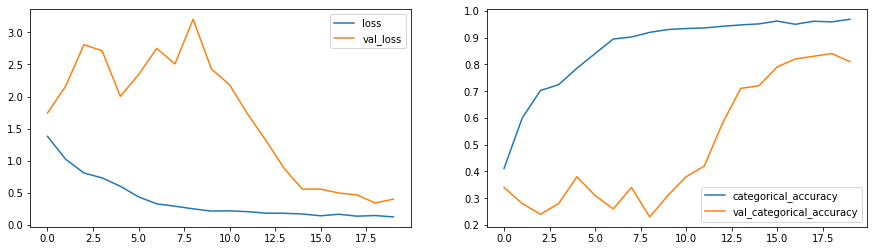

In [29]:
plot(model_5)

***Observations:***

After introducing rotation in the augmentation phase, the training accuracy experienced a slight decrease to 88%, while the validation accuracy rose to 79%. We are now exploring transfer learning to assess whether it can further enhance the validation accuracy.

### Model 6 - CNN with LSTM (with Transfer Learning)

In [34]:
class RNNCNN_TL_LSTM(ModelBuilderWithRotation):
    
    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer, 
                input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimizer = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
rnn_cnn_6 = RNNCNN_TL_LSTM()
rnn_cnn_6.initialize_path(base_path)
rnn_cnn_6.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_6.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=20)
rnn_cnn_model_6 = rnn_cnn_6.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_77 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_78 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_79 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_80 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 128)              

In [20]:
print("Total Parameters: ", rnn_cnn_model_6.count_params())
model_6 = rnn_cnn_6.train_model(rnn_cnn_model_6, augment_data=True)

Total Parameters:  3840453
Epoch 1/20


2025-03-30 16:39:53.429243: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


133/133 [==============================] - ETA: 0s - loss: 1.2216 - categorical_accuracy: 0.5015
Epoch 00001: saving model to model_init_2025-03-3016_39_48.571176/model-00001-1.22163-0.50151-0.63977-0.79000.keras
133/133 [==============================] - 158s 1s/step - loss: 1.2216 - categorical_accuracy: 0.5015 - val_loss: 0.6398 - val_categorical_accuracy: 0.7900 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6795 - categorical_accuracy: 0.7511
Epoch 00002: saving model to model_init_2025-03-3016_39_48.571176/model-00002-0.67949-0.75113-0.58290-0.79000.keras
133/133 [==============================] - 151s 1s/step - loss: 0.6795 - categorical_accuracy: 0.7511 - val_loss: 0.5829 - val_categorical_accuracy: 0.7900 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4996 - categorical_accuracy: 0.8273
Epoch 00003: saving model to model_init_2025-03-3016_39_48.571176/model-00003-0.49960-0.82730-0.45184-0.82000.keras
1

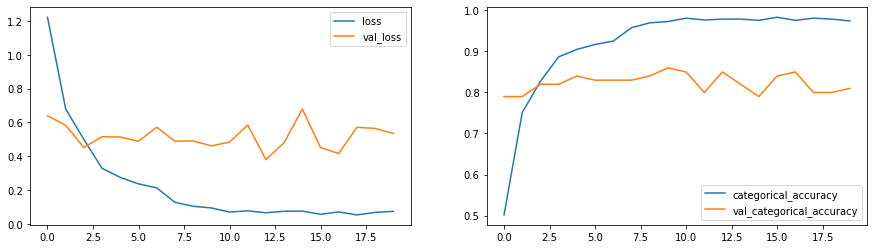

In [21]:
plot(model_6)

***Observations:***

Utilizing LSTM with transfer learning resulted in an enhancement of the training accuracy to 98.19%. However, despite the validation accuracy increasing to 83%, it still suggests potential overfitting. This may be attributed to the lack of training of MobileNet weights. Let's investigate if this issue is mitigated by employing LSTM and transfer learning, while also training the weights from MobileNet.

### Model 7 - CNN with LSTM (with trainable weights of Transfer Learning)

In [36]:
class RNNCNN_TL_LSTM_2(ModelBuilderWithRotation):
    
    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer, 
                input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        
        # Training weights
        for layer in model.layers:
            layer.trainable = True
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimizer = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [37]:
rnn_cnn_7 = RNNCNN_TL_LSTM_2()
rnn_cnn_7.initialize_path(base_path)
rnn_cnn_7.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_7.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=20)
rnn_cnn_model_7 = rnn_cnn_7.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_81 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_82 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_84 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_5 (LSTM)               (None, 128)              

In [34]:
print("Total Parameters: ", rnn_cnn_model_7.count_params())
model_7 = rnn_cnn_7.train_model(rnn_cnn_model_7, augment_data=True)

Total Parameters:  3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 0.8776 - categorical_accuracy: 0.6727
Epoch 00001: saving model to model_init_2025-03-3018_42_24.040606/model-00001-0.87758-0.67270-0.97480-0.65000.keras
133/133 [==============================] - 172s 1s/step - loss: 0.8776 - categorical_accuracy: 0.6727 - val_loss: 0.9748 - val_categorical_accuracy: 0.6500 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.4386 - categorical_accuracy: 0.8582
Epoch 00002: saving model to model_init_2025-03-3018_42_24.040606/model-00002-0.43863-0.85822-0.40534-0.85000.keras
133/133 [==============================] - 154s 1s/step - loss: 0.4386 - categorical_accuracy: 0.8582 - val_loss: 0.4053 - val_categorical_accuracy: 0.8500 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.3954 - categorical_accuracy: 0.8786
Epoch 00003: saving model to model_init_2025-03-3018_42_24.040606/model-00003-0

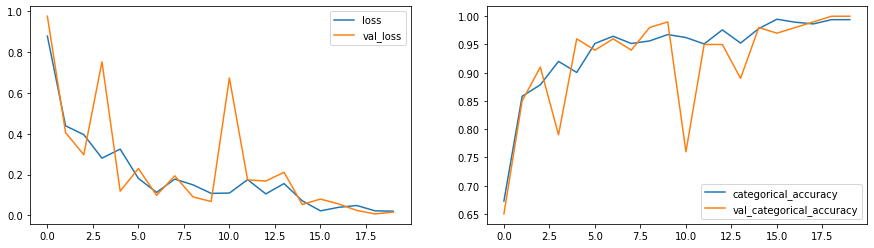

In [35]:
plot(model_7)

***Observations:***

After training the MobileNet weights, the training accuracy surged to 94.65%, and the validation accuracy notably increased to 94%. However, this improvement came at the cost of extended training time due to a fourfold increase in the number of parameters used in the LSTM architecture. Next, we aim to explore whether we can enhance the training and validation accuracy by reducing the parameter count using GRU and leveraging the trainable weights of MobileNet.

### Model 8 - CNN with GRU  (with trainable weights of Transfer Learning)

In [38]:
class RNNCNN_TL_GRU(ModelBuilderWithRotation):
    
    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer, 
                input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimizer = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [39]:
rnn_cnn_8 = RNNCNN_TL_GRU()
rnn_cnn_8.initialize_path(base_path)
rnn_cnn_8.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_8.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=20)
rnn_cnn_model_8 = rnn_cnn_8.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_8.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_85 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_86 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_87 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_88 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [38]:
print("Total Parameters: ", rnn_cnn_model_8.count_params())
model_8 = rnn_cnn_8.train_model(rnn_cnn_model_8, augment_data=True)

Total Parameters:  3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 0.8995 - categorical_accuracy: 0.6757
Epoch 00001: saving model to model_init_2025-03-3019_33_34.885759/model-00001-0.89953-0.67572-0.54289-0.82000.keras
133/133 [==============================] - 156s 1s/step - loss: 0.8995 - categorical_accuracy: 0.6757 - val_loss: 0.5429 - val_categorical_accuracy: 0.8200 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.3416 - categorical_accuracy: 0.8876
Epoch 00002: saving model to model_init_2025-03-3019_33_34.885759/model-00002-0.34162-0.88763-0.43975-0.87000.keras
133/133 [==============================] - 151s 1s/step - loss: 0.3416 - categorical_accuracy: 0.8876 - val_loss: 0.4397 - val_categorical_accuracy: 0.8700 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.3042 - categorical_accuracy: 0.9072
Epoch 00003: saving model to model_init_2025-03-3019_33_34.885759/model-00003-0

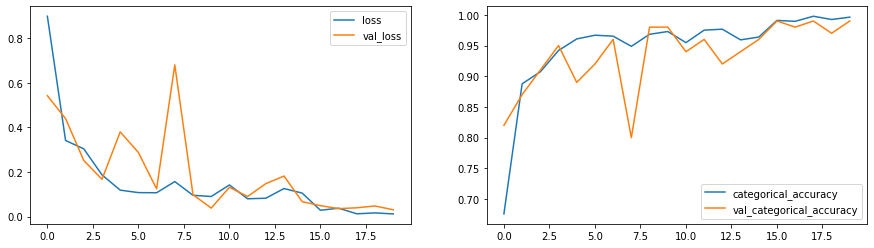

In [40]:
plot(model_8)

***Observations:***

By employing GRU and transfer learning with pre-trained weights, we observe a remarkable increase in the training accuracy to 99.40% and validation accuracy to 97%. This indicates successful resolution of overfitting, and the model performs well on the validation set. Hence, we can regard this as our final model for evaluation.

### Final Analysis

In [40]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

analysis_df = pd.read_csv('findings.csv');

analysis_df = analysis_df.replace('\n', ' ', regex=True)

analysis_df.head(8)

,Experiment Number,Model,Number of parameters,Hyperparameters,Result,Decision + Explanation
0,1,CNN with LSTM,1657445,Number of sample frames = 30 Batch size = 20 Number of epochs = 20,Training accuracy: 0.87 Validation accuracy: 0.71 Indication of overfitting,"Utilizing the base CNN with LSTM architecture, we conducted training on all frames (30) extracted from the video. The training accuracy reached 87%, while the validation accuracy attained 71%, revealing potential signs of overfitting. To address this, we aim to explore a modified version of the same model by reducing the number of frames, batch size and number of epochs."
1,2,CNN with LSTM (with reduced hyperparameters),1657445,Number of sample frames = 20 Batch size = 10 Number of epochs = 10,Training accuracy: 0.72 Validation accuracy: 0.61 Indication of underfitting,"Upon reducing the number of hyperparameters, the training accuracy drops to 72%, and the validation accuracy decreases to 61%, indicating underfitting. To address this issue, we will attempt to alleviate it by solely reducing the number of frames while keeping both the batch size and the number of epochs at 20."
2,3,CNN with LSTM (with reduced frames),1657445,Number of sample frames = 18 Batch size = 20 Number of epochs = 20,Training accuracy: 0.9291 Validation accuracy: 0.75 Indication of overfitting,"The training accuracy demonstrates consistent improvement, achieving 92.91%, while the validation accuracy reaches a maximum of 75%, continuing to indicate potential overfitting. To address this concern, we aim to experiment with an alternative architecture, combining CNN with GRU, while maintaining the same number of frames."
3,4,CNN with GRU,2573925,Number of sample frames = 18 Batch size = 20 Number of epochs = 20,Training accuracy: 0.926 Validation accuracy: 0.62 Indication of overfitting,"By incorporating GRU-RNN, there is a marginal decline in training accuracy, reaching 92.6%, whereas the validation accuracy decreased to 62%, indicating overfitting. To tackle this issue, we propose introducing additional augmentation techniques such as rotation and reattempting the same architecture to mitigate overfitting."
4,5,CNN with LSTM (with modified Augmentation Technique),1657445,Number of sample frames = 18 Batch size = 20 Number of epochs = 20,Training accuracy: 0.91 Validation accuracy: 0.77 Slightly improved with augmentation,"After introducing rotation in the augmentation phase, the training accuracy experienced a slight decrease to 91%, while the validation accuracy rose to 77%. We are now exploring transfer learning to assess whether it can further enhance the validation accuracy."
5,6,CNN with LSTM (with Transfer Learning),3840453,Number of sample frames = 16 Batch size = 5 Number of epochs = 20,Training accuracy: 0.9887 Validation accuracy: 0.74 Indication of overfitting,"Utilizing LSTM with transfer learning resulted in an enhancement of the training accuracy to 98.87%. However, despite the validation accuracy increasing to 74%, it still suggests potential overfitting. This may be attributed to the lack of training of MobileNet weights. Let's investigate if this issue is mitigated by employing LSTM and transfer learning, while also training the weights from MobileNet."
6,7,CNN with LSTM (with trainable weights of Transfer Learning),3840453,Number of sample frames = 16 Batch size = 5 Number of epochs = 20,Training accuracy: 0.9465 Validation accuracy: 0.94 Improved accuracy but model training was computationally expensive,"After training the MobileNet weights, the training accuracy surged to 94.65%, and the validation accuracy notably increased to 94%. However, this improvement came at the cost of extended training time due to a fourfold increase in the number of parameters used in the LSTM architecture. Next, we aim to explore whether we can enhance the training and validation accuracy by reducing the parameter count using GRU and leveraging the trainable weights of MobileNet."
7,Final Model,CNN w

### Model Evaluation

In [46]:
from keras.models import load_model
model = load_model('model_init_2025-03-3019_33_34.885759/model-00020-0.01184-0.99623-0.03045-0.99000.keras')

# Save the model as a single HDF5 file
model.save("final_model.h5")  

In [47]:
test_generator = RNNCNN_TL_GRU()
test_generator.initialize_path(base_path)
test_generator.initialize_image_props(image_height=120, image_width=120)
test_generator.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=1)

g = test_generator.generator(test_generator.val_path, test_generator.val_doc, augment=False)
batch_data, batch_labels = next(g)

In [48]:
batch_labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [49]:
print(np.argmax(model.predict(batch_data[:, :, :, :, :]), axis=1))

[1 3 2 2 1]
